In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from matplotlib.patches import Rectangle
import folium
from folium.plugins import HeatMap
from matplotlib.patches import Rectangle
from scipy.stats import chi2_contingency

In [ ]:
# Load the dataset
terrorism_df = pd.read_csv(r"C:\Users\shric\Desktop\Dai\assignments\midterm\effective_terrorism_tactics_exploration\data\globalterrorismdb_0522dist.csv")

C:\Users\shric\AppData\Local\Temp\ipykernel_720\1846187726.py:2: DtypeWarning: Columns (4,31,33,54,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  terrorism_df = pd.read_csv(r"C:\Users\shric\Desktop\Dai\assignments\midterm\effective_terrorism_tactics_exploration\data\globalterrorismdb_0522dist.csv")


In [ ]:
# Clean the dataset
columns_to_remove = ["imonth", "iday", "approxdate", "extended", "specificity", "property", "resolution", "claimmode", "claimmode_txt", "claim2", "claimmode2", "claimmode2_txt", "claim3", "claimmode3", "claimmode3_txt", "compclaim", "propextent", "propextent_txt", "propvalue", "propcomment", "nhours", "ndays", "addnotes", "scite1", "scite2", "scite3", "dbsource", "INT_LOG", "INT_IDEO", "INT_MISC", "INT_ANY", "location", "alternative", "alternative_txt", "provstate", "city"]
cleaned_terrorism_df = terrorism_df.drop(columns=columns_to_remove)

In [ ]:
# Number Columns Only
number_columns = cleaned_terrorism_df.select_dtypes(include=['int64', 'int32', 'float64'])


In [ ]:
# Object Columns Only
object_columns = cleaned_terrorism_df.select_dtypes(include=['object'])


In [ ]:
# Define parameters for Terrorism Attacks
drop_attacks = cleaned_terrorism_df[~cleaned_terrorism_df['attacktype1_txt'].isin(['Unknown', 'Hostage Taking (Barricade Incident)', 'Unarmed Assault', 'Hostage Taking (Kidnapping)'])]

# Verify the removal by checking the unique values in the 'attacktype1_txt' column
print(drop_attacks['attacktype1_txt'].unique())

['Assassination' 'Bombing/Explosion' 'Facility/Infrastructure Attack'
 'Armed Assault' 'Hijacking']


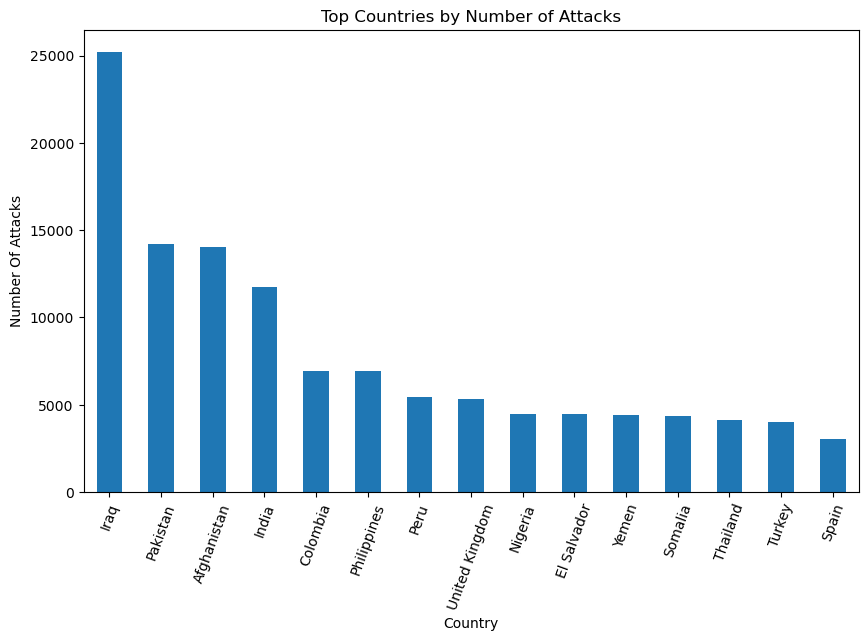

In [ ]:
# Visualize top countries by number of attacks
top_countries = drop_attacks['country_txt'].value_counts().head(15)
plt.figure(figsize=(10,6))
top_countries.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number Of Attacks')
plt.title('Top Countries by Number of Attacks')
plt.xticks(rotation=70)
plt.show()

In [ ]:
# Count the number of each type of attack
attack_counts = drop_attacks['attacktype1_txt'].value_counts().head(5)

# Set index as attack count
filtered_df = drop_attacks[drop_attacks['attacktype1_txt'].isin(attack_counts.index)]

# Count number of attacks per country
country_attack_counts = filtered_df.groupby(['country_txt', 'attacktype1_txt']).size().unstack(fill_value=0)

# Set index for country attacks
country_attack_counts = country_attack_counts.loc[top_countries.index].reset_index().melt(id_vars='country_txt', var_name='Type of Attack', value_name='Number of Attacks')

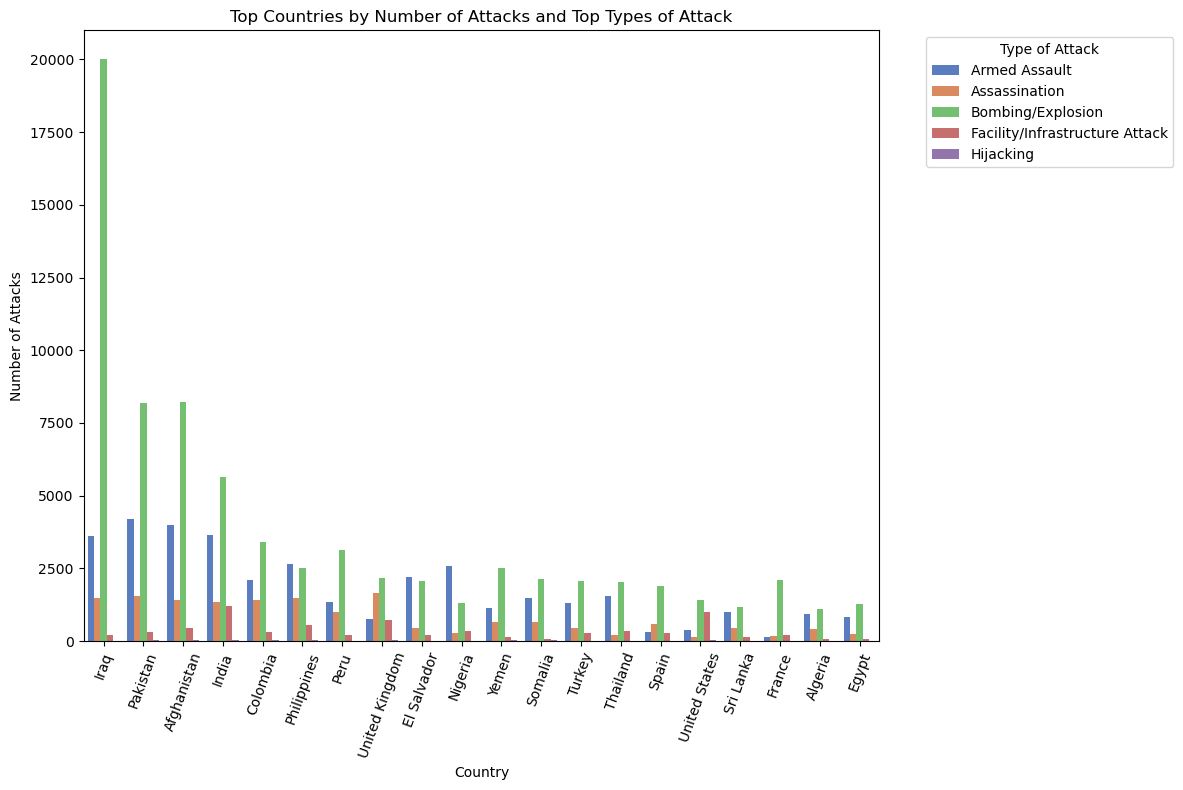

In [ ]:
# Visualize number of attacks by attack type and country
plt.figure(figsize=(12, 8))
sns.barplot(data=country_attack_counts, x='country_txt', y='Number of Attacks', hue='Type of Attack', palette='muted')
plt.xlabel('Country')
plt.ylabel('Number of Attacks')
plt.title('Top Countries by Number of Attacks and Top Types of Attack')
plt.legend(title='Type of Attack', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

C:\Users\shric\AppData\Local\Temp\ipykernel_720\2828936471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_attacks['iyear'] = pd.to_datetime(drop_attacks['iyear'], format='%Y')


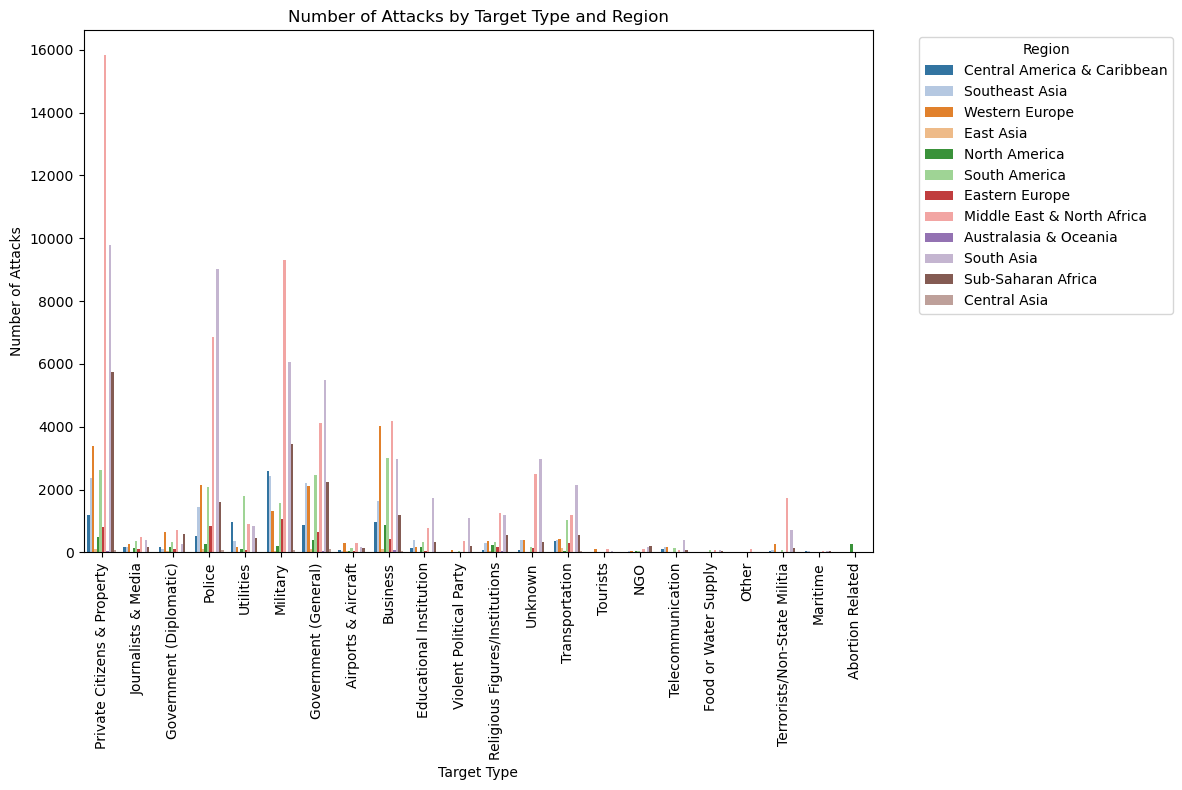

In [ ]:
# Number of attacks over the years
drop_attacks['iyear'] = pd.to_datetime(drop_attacks['iyear'], format='%Y')
plt.figure(figsize=(12, 8))
sns.countplot(data=drop_attacks, x='targtype1_txt', hue='region_txt', palette='tab20')
plt.xlabel('Target Type')
plt.ylabel('Number of Attacks')
plt.title('Number of Attacks by Target Type and Region')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

C:\Users\shric\AppData\Local\Temp\ipykernel_720\3104223387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_attacks['iyear'] = pd.to_datetime(drop_attacks['iyear'], format='%Y')


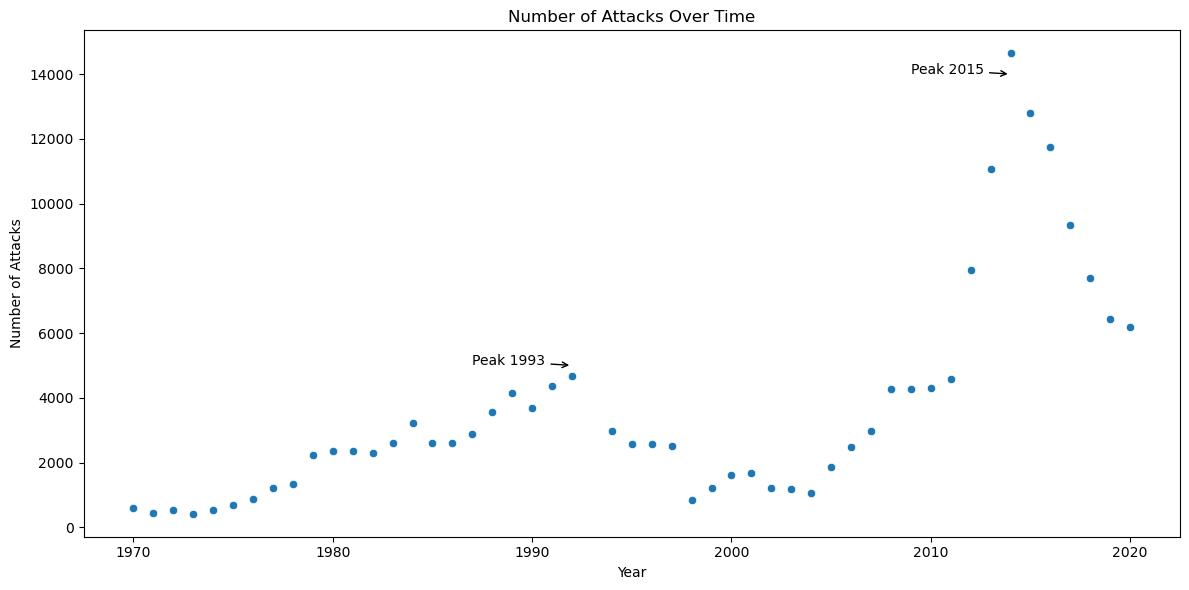

In [ ]:
# Visualize temporal trends
drop_attacks['iyear'] = pd.to_datetime(drop_attacks['iyear'], format='%Y')
attacks_over_time = drop_attacks['iyear'].dt.year.value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.scatterplot(x=attacks_over_time.index, y=attacks_over_time.values)
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.title('Number of Attacks Over Time')
plt.annotate('Peak 2015', xy=(2014, 14000), xytext=(2009, 14000), arrowprops=dict(facecolor='Red', arrowstyle='->'))
plt.annotate('Peak 1993', xy=(1992, 5000), xytext=(1987, 5000), arrowprops=dict(facecolor='Red', arrowstyle='->'))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize attacks on map
drop_attacks.dropna(subset=['latitude', 'longitude'], inplace=True)
map_center = [drop_attacks['latitude'].mean(), drop_attacks['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=2)
heat_data = [[row['latitude'], row['longitude']] for index, row in drop_attacks.iterrows()]  # Corrected variable name
HeatMap(heat_data, radius=5, blur=2, gradient={0.4: 'blue', 0.65: 'yellow', 1: 'red'}).add_to(mymap)
mymap

C:\Users\shric\AppData\Local\Temp\ipykernel_720\2874920679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_attacks.dropna(subset=['latitude', 'longitude'], inplace=True)


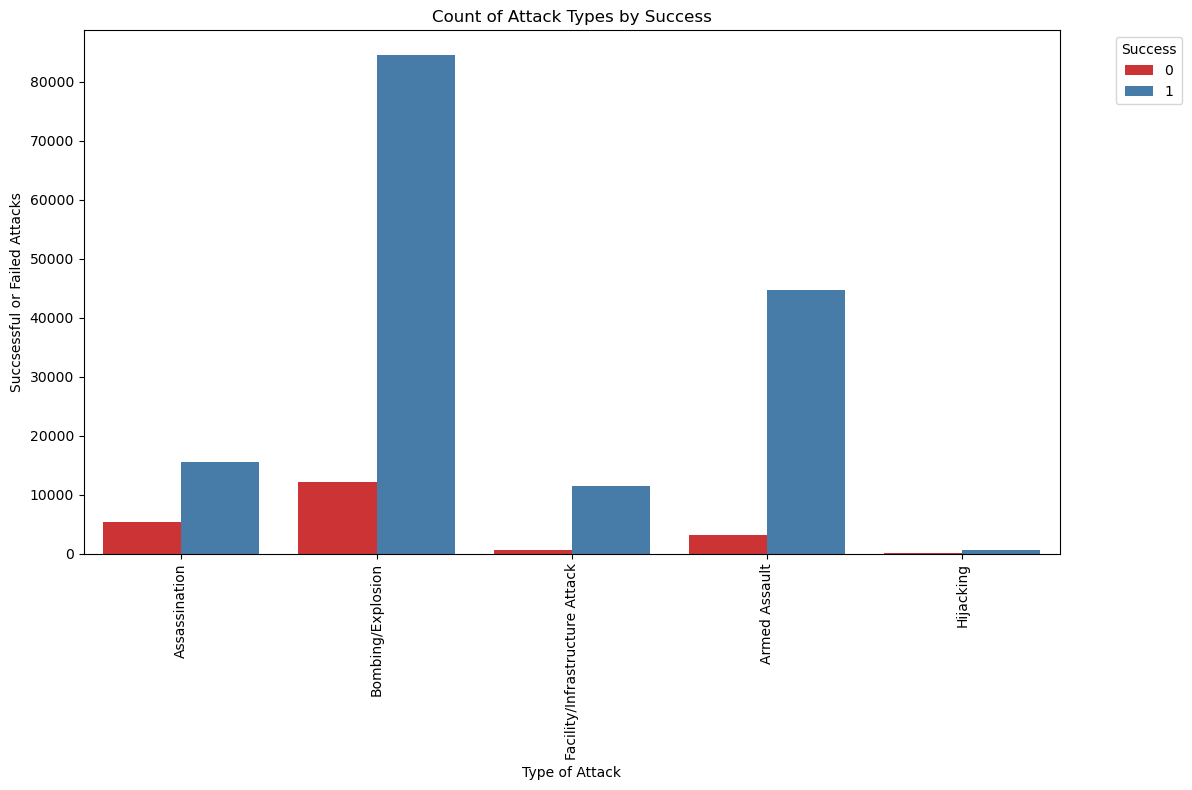

In [ ]:
# Visualize correlation analysis
plt.figure(figsize=(12, 8))
sns.countplot(data=drop_attacks, x='attacktype1_txt', hue='success', palette='Set1')
plt.xlabel('Type of Attack')
plt.ylabel('Succsessful or Failed Attacks')
plt.title('Count of Attack Types by Success')
plt.legend(title='Success', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

C:\Users\shric\AppData\Local\Temp\ipykernel_720\1515434249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_attacks['year'] = drop_attacks['iyear'].dt.year


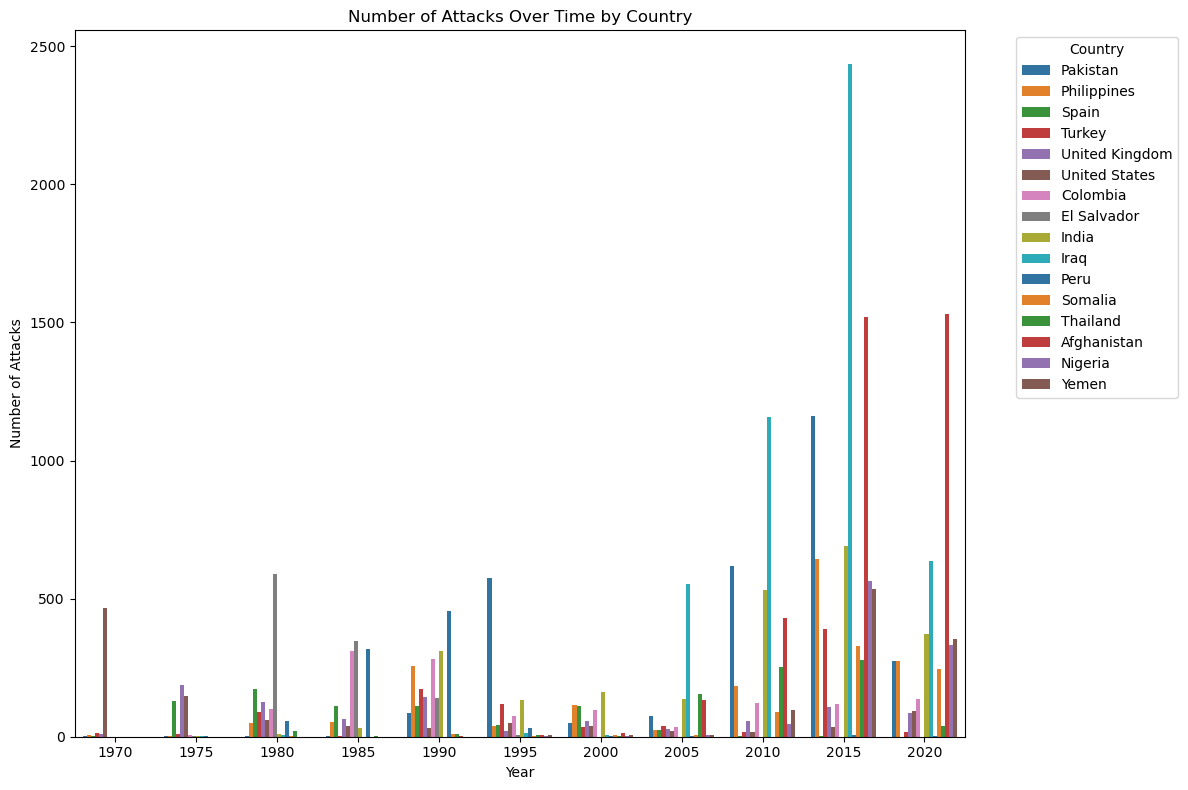

In [ ]:
# Visualize number of attacks over time by country
drop_attacks['year'] = drop_attacks['iyear'].dt.year
attacks_over_time_by_country = drop_attacks.groupby(['year', 'country_txt']).size().reset_index(name='num_attacks')
top_countries = drop_attacks['country_txt'].value_counts().head(16).index
attacks_over_time_by_country = attacks_over_time_by_country[attacks_over_time_by_country['country_txt'].isin(top_countries)]
attacks_over_time_by_country = attacks_over_time_by_country[attacks_over_time_by_country['year'] % 5 == 0]
plt.figure(figsize=(12, 8))
sns.barplot(data=attacks_over_time_by_country, x='year', y='num_attacks', hue='country_txt', palette='tab10')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.title('Number of Attacks Over Time by Country')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Create attacks by Reigon
attacks_by_region_type = drop_attacks.groupby(['region_txt', 'attacktype1_txt']).size().reset_index(name='attack_count')

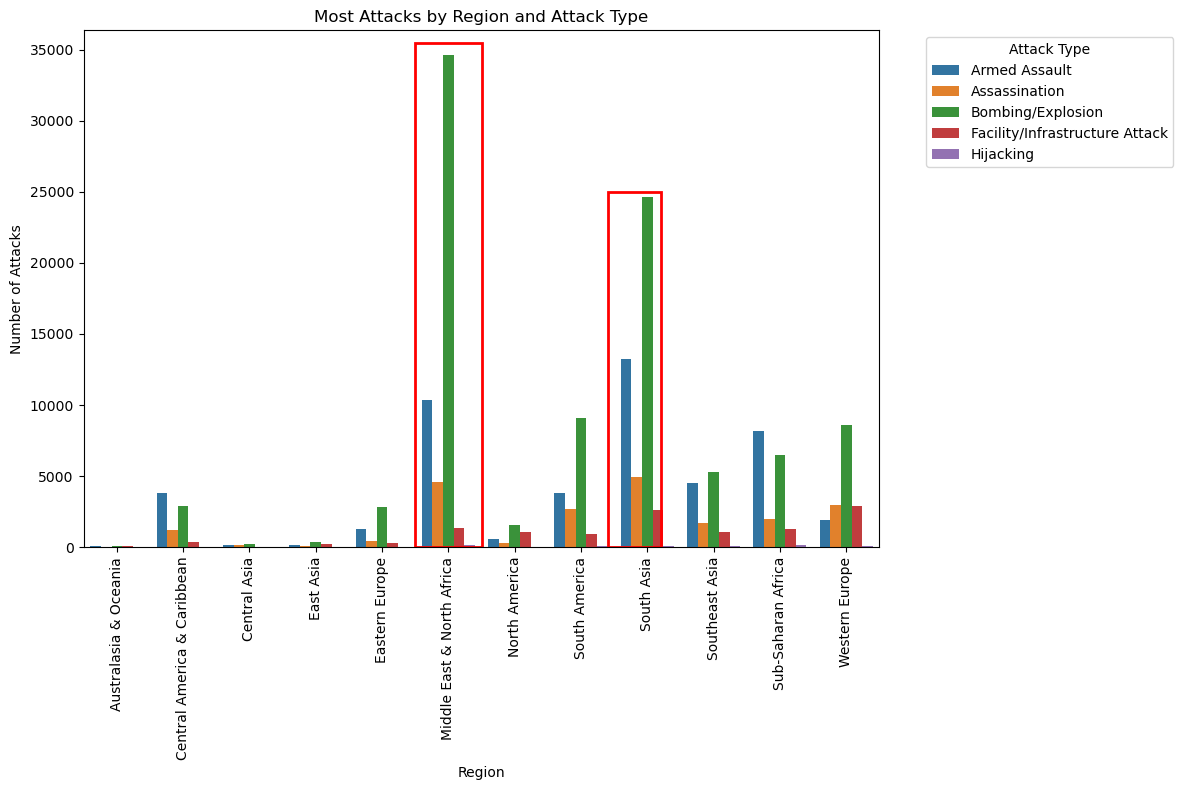

In [ ]:
# Visualize number of attacks by region and type
plt.figure(figsize=(12, 8))
sns.barplot(data=attacks_by_region_type, x='region_txt', y='attack_count', hue='attacktype1_txt', palette='tab10')
plt.xlabel('Region')
plt.ylabel('Number of Attacks')
plt.title('Most Attacks by Region and Attack Type')
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.gca().add_patch(Rectangle((7.4, 0), 0.8, 25000, edgecolor='red', facecolor='none', linewidth=2))  # Middle East & North Africa
plt.gca().add_patch(Rectangle((4.5, 0), 1, 35500, edgecolor='red', facecolor='none', linewidth=2))  # South Asia
plt.show()

In [ ]:
# Visualize chi-square test
contingency_table = pd.crosstab(drop_attacks['attacktype1_txt'], drop_attacks['targtype1_txt'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 55838.765561864464
P-value: 0.0


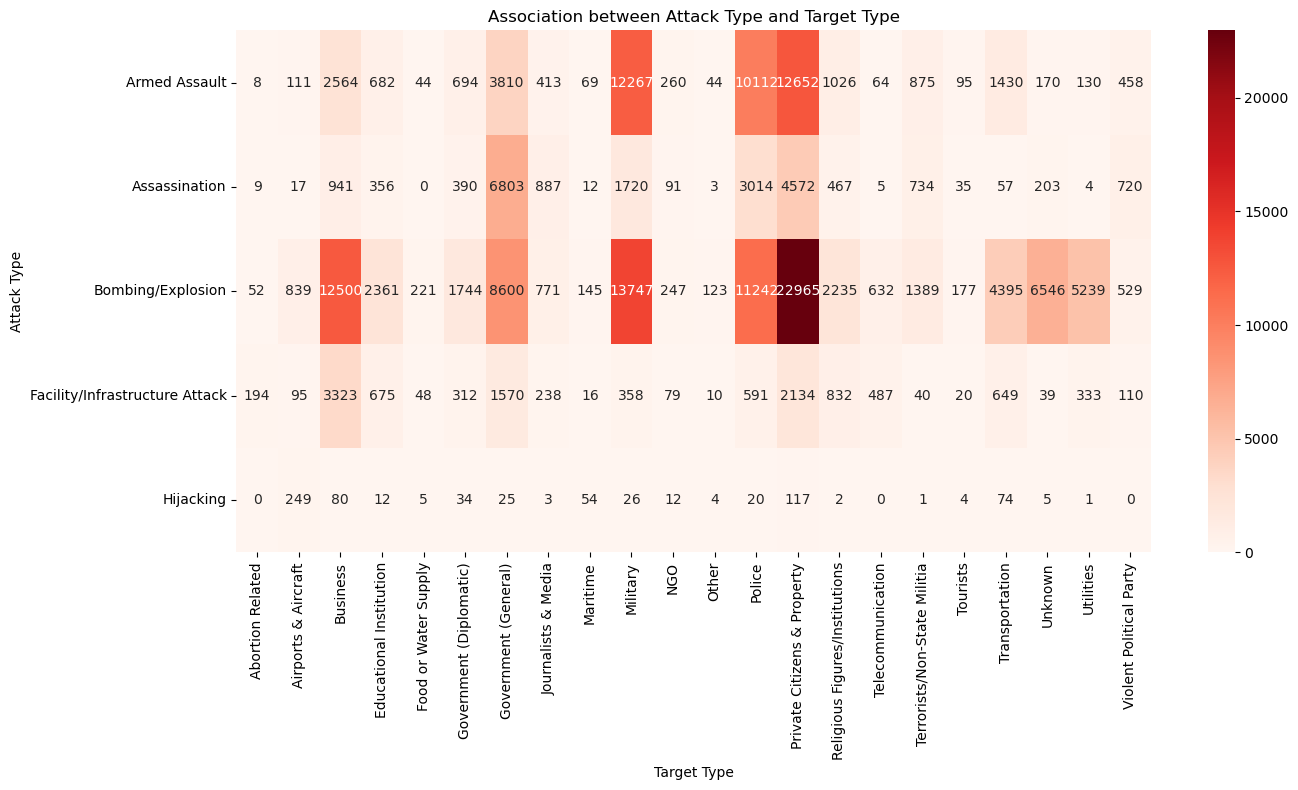

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(drop_attacks['attacktype1_txt'], drop_attacks['targtype1_txt'])
plt.figure(figsize=(14, 8))
sns.heatmap(contingency_table, cmap='Reds', annot=True, fmt='d')
plt.xlabel('Target Type')
plt.ylabel('Attack Type')
plt.title('Association between Attack Type and Target Type')
plt.tight_layout()
plt.show()

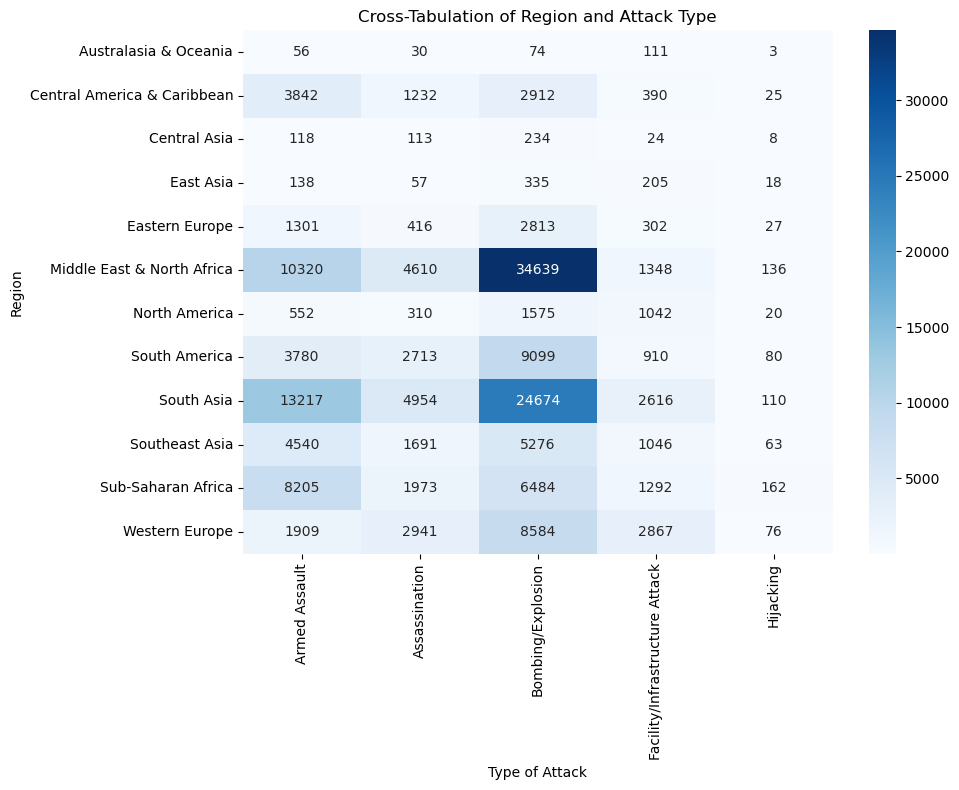

In [ ]:
# Plot cross-tabulation table
cross_tab = pd.crosstab(drop_attacks['region_txt'], drop_attacks['attacktype1_txt'])
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt="d")
plt.title('Cross-Tabulation of Region and Attack Type')
plt.xlabel('Type of Attack')
plt.ylabel('Region')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

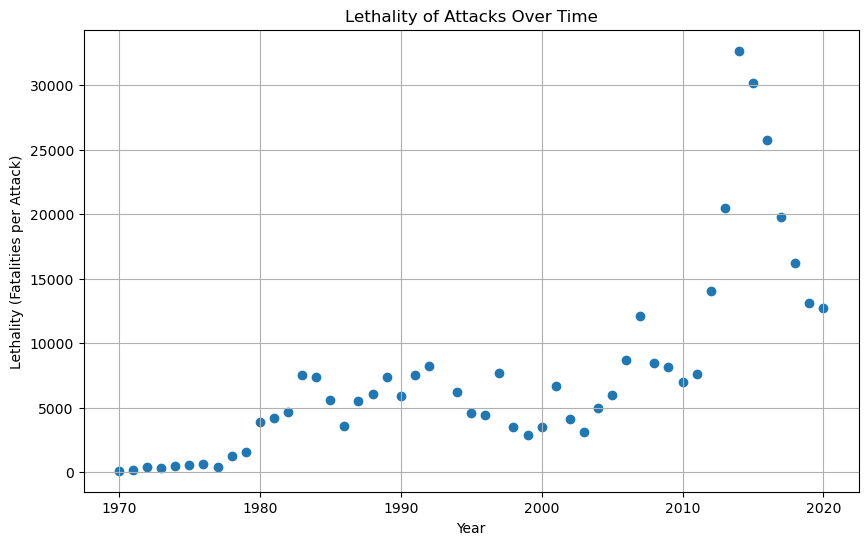

In [ ]:
attacks_fatalities_by_year = drop_attacks.groupby('iyear').agg({'eventid': 'count', 'nkill': 'sum'}).reset_index()

# Calculate lethality (fatalities per attack)
attacks_fatalities_by_year['lethality'] = attacks_fatalities_by_year['nkill']

# Plot lethality over time
plt.figure(figsize=(10, 6))
plt.scatter(attacks_fatalities_by_year['iyear'], attacks_fatalities_by_year['lethality'], marker='o')
plt.xlabel('Year')
plt.ylabel('Lethality (Fatalities per Attack)')
plt.title('Lethality of Attacks Over Time')
plt.grid(True)
plt.show()

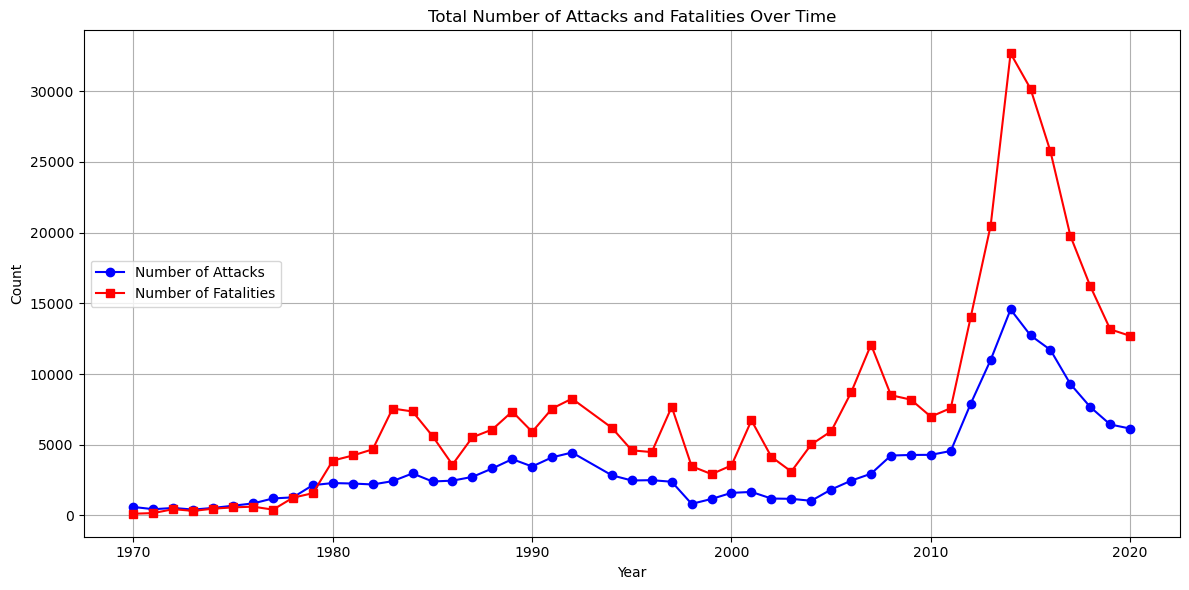

In [ ]:
# Calculate the total number of attacks and fatalities per year
attacks_fatalities_by_year = drop_attacks.groupby('iyear').agg({'eventid': 'count', 'nkill': 'sum'}).reset_index()

# Visualize both the total number of attacks and fatalities over time
plt.figure(figsize=(12, 6))

# Plot the total number of attacks over time
plt.plot(attacks_fatalities_by_year['iyear'], attacks_fatalities_by_year['eventid'], color='blue', marker='o', label='Number of Attacks')

# Plot the total number of fatalities over time
plt.plot(attacks_fatalities_by_year['iyear'], attacks_fatalities_by_year['nkill'], color='red', marker='s', label='Number of Fatalities')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Total Number of Attacks and Fatalities Over Time')

# Add legend
plt.legend(loc= 'center left')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
most_attacks_year = drop_attacks['iyear'].value_counts().idxmax()
num_attacks_most_year = drop_attacks['iyear'].value_counts().max()
print("Year with the most attacks:", most_attacks_year)
print("Number of attacks in the most attacked year:", num_attacks_most_year)

Year with the most attacks: 2014-01-01 00:00:00
Number of attacks in the most attacked year: 14568


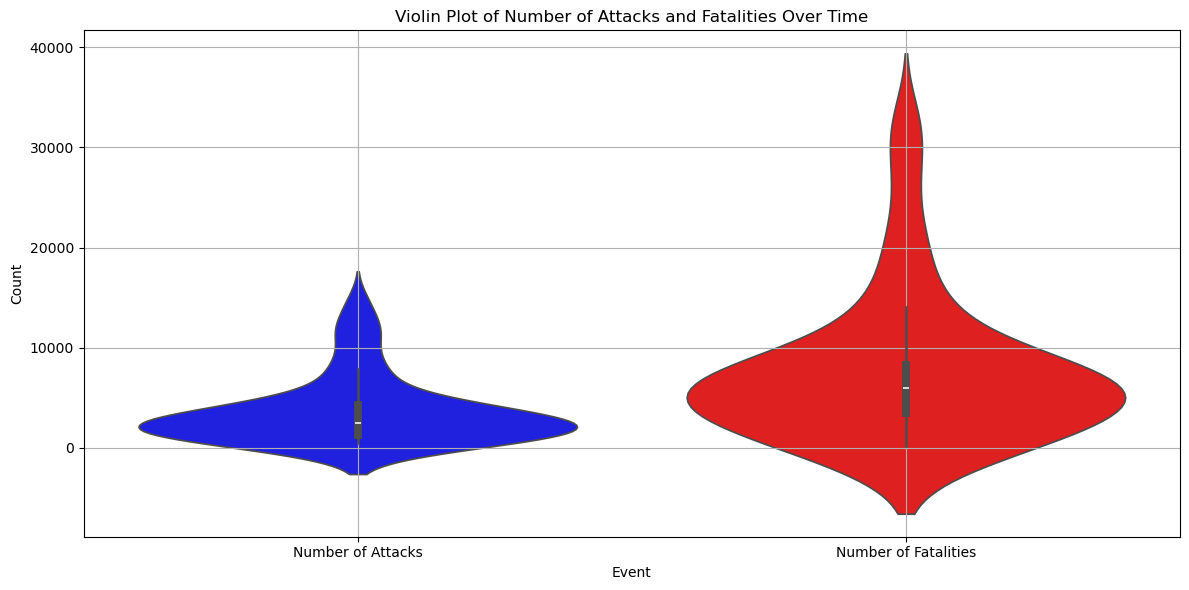

In [ ]:
# Create a violin plot
plt.figure(figsize=(12, 6))

# Plot the violin plot for the number of attacks and fatalities
sns.violinplot(data=attacks_fatalities_by_year[['eventid', 'nkill']], palette=['blue', 'red'])
plt.xlabel('Event')
plt.ylabel('Count')
plt.title('Violin Plot of Number of Attacks and Fatalities Over Time')
plt.xticks(ticks=[0, 1], labels=['Number of Attacks', 'Number of Fatalities'])

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()